# Large-Domain Animation and Figures

This Notebook generates large-domain prediction plots and animations.  It is principally designed for a CONUS-scale run prepared for AGU24.  It is assumed that predictions are already available.

The run in question involves ~100k points for ~20 years.  At daily resolution, this is a few tens of gigabytes of data, which is obviously unworkable.  Instead, we're going to use the 7-day mean from 2018-2022 (arbitrarily).  So the first thing we have to do is reorganize the data, incrementally.

Then the plot.  ~100k pour point temperatures is, if square and evenly distributed, about 300x300, which should be visible at high resolution, though it's going to look like more of a surface than a river network in a lot of places.  Hopefully the images will compress reasonably well.

Note that Wendian doesn't have imagemagick or ffmpeg available for writing .mp4s (so it has to be a GIF), but the output CSV can be downloaded and used with this notebook locally to make an mp4 version.  Be aware that this is a rather memory-intensive operation; with ~14,000 watersheds, it required up to 3.5 GB and ran for several minutes.  Note also that one should use ffmpeg, not magick, since the latter requires the former anyway.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
import geopandas as gpd
outpath = "/scratch/dphilippus/pyproc/CONUS2021.csv"

# Reorganize Data

First things first: incrementally grab lat, lon, date, temperature for each river for 2018-2022 only, aggregate to weekly, and put that in one big file.  While we're at it, we'll filter for at least a year of coverage, to avoid clutter.

In [4]:
import os
inpath = "/scratch/dphilippus/pyproc/CONUS12/"

In [5]:
inputs = os.listdir(inpath)
print(len(inputs))
append = False
counter = 0
for inp in inputs:
    dat = pd.read_csv(inpath + inp, dtype={"id": "str"}, parse_dates=["date"])
    dat["week"] = dat["date"].dt.isocalendar().week
    dat["year"] = dat["date"].dt.year
    if not "area" in dat.columns:
        dat["area"] = 1e8  # default: small HUC12, ~10km x 10km
    dat = dat[(dat["date"] >= "2018-01-01") & (dat["date"] < "2023-01-01")][
        ["date", "year", "week", "lat", "lon", "area", "temp.mod"]].dropna().\
        groupby(["year", "week"]).agg({"date": "first", "lat": "first", "lon": "first", "area": "first", "temp.mod": "mean"})
    if len(dat) > 50:
        dat.to_csv(outpath, header=not append, mode='a' if append else 'w')
        append = True
    if counter % 300 == 0:
        print("|", end="")
    if counter % 3000 == 0:
        print(counter, end="")
    counter += 1

27199
|0||||||||||3000||||||||||6000||||||||||9000||||||||||12000||||||||||15000||||||||||18000||||||||||21000||||||||||24000||||||||||27000

# Load Data and Make Individual Plots

US states shapefile: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [2]:
data = pd.read_csv(outpath, parse_dates=["date"])
data = data[(data["temp.mod"] > -1) & (data["temp.mod"] < 40)]
data["date"] = data["date"].dt.normalize()
data

,year,week,date,lat,lon,area,temp.mod
0,2018,1,2018-01-01,41.920684,-114.990976,58690000.0,2.237928
1,2018,2,2018-01-08,41.920684,-114.990976,58690000.0,1.486368
2,2018,3,2018-01-15,41.920684,-114.990976,58690000.0,1.513376
3,2018,4,2018-01-22,41.920684,-114.990976,58690000.0,1.067670
4,2018,5,2018-01-29,41.920684,-114.990976,58690000.0,2.948608
...,...,...,...,...,...,...,...
7126133,2022,48,2022-11-28,36.415789,-99.807017,84210000.0,10.011584
7126134,2022,49,2022-12-05,36.415789,-99.807017,84210000.0,11.184945
7126135,2022,50,2022-12-12,36.415789,-99.807017,84210000.0,8.161798
7126136,2022,51,2022-12-19,36.415789,-99.807017,84210000.0,5.050585


In [3]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]  # lower 48

/tmp/ipykernel_581734/2190876473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jul["rel_area"] = jul["area"] / jul["area"].max() * 8


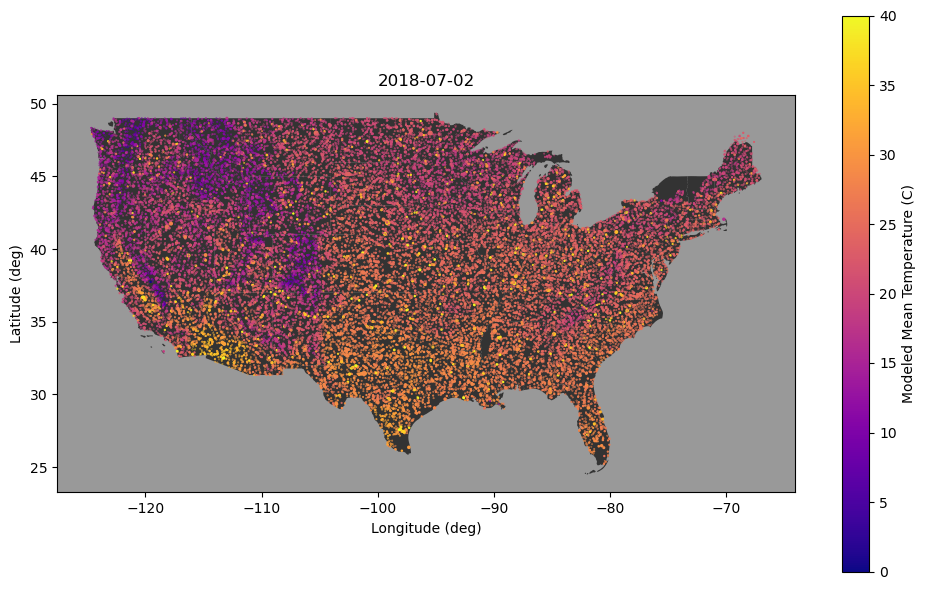

In [54]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(facecolor="#999")
jul = data[data["date"] == "2018-07-02"]
jul["rel_area"] = jul["area"] / jul["area"].max() * 8
def dofig(data, ax, title, nocb=False, tight=True):
    states.plot(ax=ax, color="#333")
    data.plot.scatter(x="lon", y="lat", c="temp.mod", title="2021-07-01", ax=ax, colormap="plasma", s="rel_area", vmin=0, vmax=40)
    cb = ax.collections[1].colorbar
    if nocb:
        cb.remove()
    else:
        cb.set_label("Modeled Mean Temperature (C)")
        ax.set_xlabel("Longitude (deg)")
        ax.set_ylabel("Latitude (deg)")
    _ = ax.set_title(title)
    if tight:
        plt.tight_layout()
dofig(jul, ax, "2018-07-02")

# Animate It!

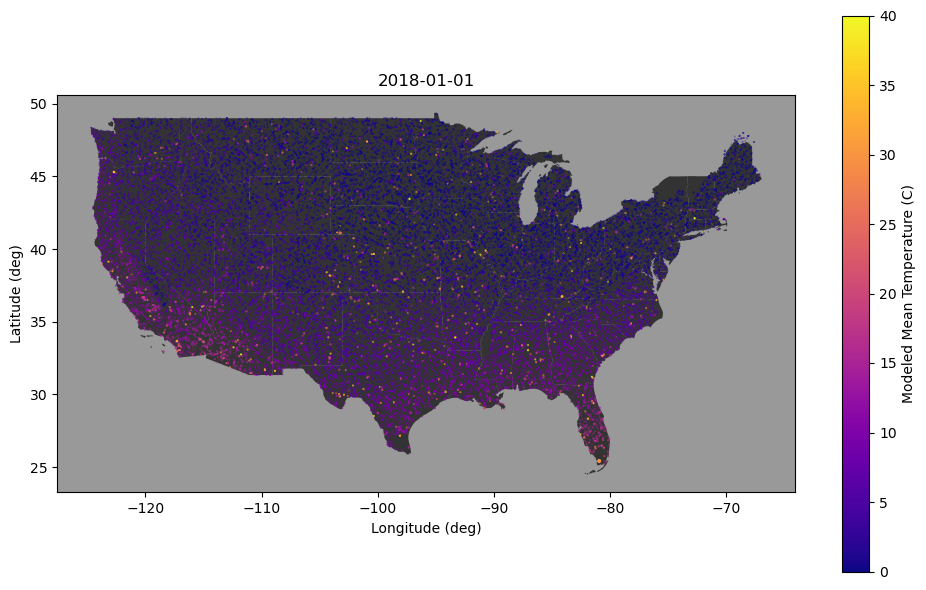

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(facecolor="#999")
dates = np.array(data["date"].unique(), dtype='datetime64[D]')
data["rel_area"] = data["area"] / data["area"].max() * 4
def animate(i):
    date = dates[i]
    fig.clear()
    ax = plt.axes(facecolor="#999")
    dofig(data[data["date"] == date], ax, str(date))
    # states.plot(ax=ax, color="#333")
    # data[data["date"] == date].plot.scatter(x="lon", y="lat", c="temp.mod", title=str(date), ax=ax, colormap="plasma", s="rel_area", vmin=0, vmax=40)
    # ax.collections[1].colorbar.set_label("Modeled Weekly Mean Temperature (C)")
    # ax.set_xlabel("Longitude (deg)")
    # ax.set_ylabel("Latitude (deg)")
    # plt.tight_layout()

a = anim.FuncAnimation(fig, animate, interval=150, frames=range(len(dates)))
a.save("conus18to22.gif")

# Make some Figures

Requested figure is four panels, with (the nearest week to):

- Winter SWT (day 30 = Jan. 30)
- Summer SWT (day 210 = Jul. 30, appx.)
- High SWT variability (calculated)
- Strong seasonality (May 1)

In [65]:
winter = data[data["date"] == "2022-01-24"]
summer = data[data["date"] == "2022-07-25"]
seasons = data[data["date"] == "2022-05-02"]
varday = data.groupby("date", as_index=False)["temp.mod"].std().sort_values("temp.mod", ascending=False).iloc[0]["date"]
variable = data[data["date"] == varday]
datasets = [
    (winter, "(A) Winter: week of Jan 24 (2022)"),
    (summer, "(B) Summer: week of Jul 25"),
    (seasons, "(C) Strong Seasonality: week of May 2"),
    (variable, "(D) High Variability: week of " + varday.strftime("%b %d"))
]

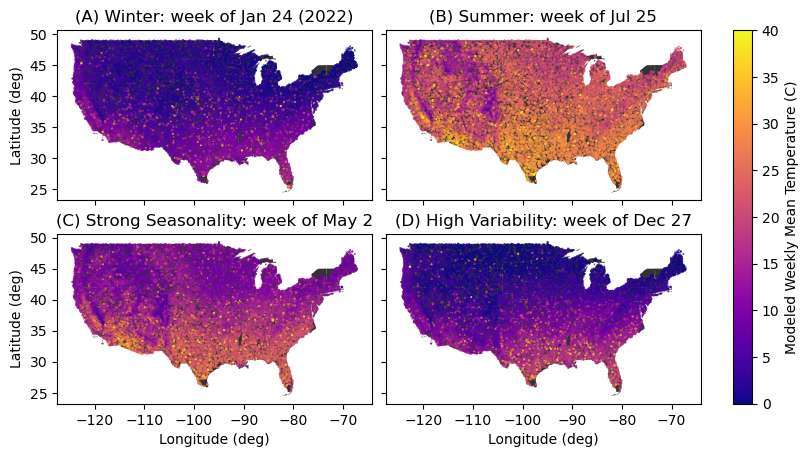

In [69]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,6), layout="compressed")
for i in range(4):
    ax = axes[i//2, i%2]
    dofig(datasets[i][0], ax, datasets[i][1], nocb=True, tight=False)
    if i > 1:
        ax.set_xlabel("Longitude (deg)")
    if i % 2 == 0:
        ax.set_ylabel("Latitude (deg)")
cb = plt.colorbar(axes[0,0].collections[1], ax=axes.ravel().tolist())
cb.set_label("Modeled Weekly Mean Temperature (C)")
plt.savefig("figures/Demo4Panel.png", dpi=1000)